# TL072/TL082 Analysis and Simulation

By Shuo Chen (chenshuo_at_chenshuo.com) [30% done]

Latest version: https://chenshuo.github.io/notes/TL082/

Jupyter source of this page: https://github.com/chenshuo/notes/blob/master/notebooks/TL082.ipynb

Comments and discussions: https://github.com/chenshuo/notes/discussions

In [1]:
%matplotlib inline

import math
from math import degrees, exp, log, log10, sqrt

# NgSpice
import ngspyce as ng

import numpy as np
from matplotlib import pyplot as plt
import scipy

def para(r1, r2):
    return (r1*r2) / (r1 + r2)

TL082/TL072 are general purpose JFET-input op amps (a.k.a. Bi-FET technology), first introduced by Texas Instruments in 1977.

> *Note:* This post doesn't talk about new TL07xH/TL08xH opamps introduced in 2020, which are CMOS opamps. We focus on those classic JFET input op amps.

$\newcommand{\li}[1]{{i_\mathrm{#1}}}$
$\newcommand{\ui}[1]{{I_\mathrm{#1}}}$
$\newcommand{\lv}[1]{{v_\mathrm{#1}}}$
$\newcommand{\uv}[1]{{V_\mathrm{#1}}}$
$\newcommand{\ur}[1]{{R_\mathrm{#1}}}$
$\newcommand{\sm}[2]{{{#1}_\mathrm{#2}}}$

The following table shows brief specs for TL072C from [TI 1996 datasheet](https://nuedc.org/opamp/tl072-1996.pdf)

| Parameter | Symbol | Unit | min | typical | max |
| --- | :-: | :-: | --: | --: | --: |
| Offset voltage | Vos | mV |    | 3   | 10  |
| Bias current | $\ui{IB}$ | pA |  | 65 | 200 |
| Input resistance | $\ur{id}$ | Ω | | $10^{12}$ | |
| Common-mode input voltage range | $\uv{CM}$ | V | $\pm 11$ | $-$12 to 15| |
| Unit-gain bandwidth | GBW | MHz | | 3 | |
|Open-loop voltage gain| $\sm{A}{VD}$ | V/mV| 25 | 200 | |
| Slew rate | SR | V/μsec | 8 | 13 | |
| Supply current (per amp) | $\ui{Q}$ | mA | | 1.4 | 2.5 |
| Input voltage noise density | $\sm{e}{N}$ | nV/$\sqrt{\mathrm{Hz}}$ | | 18 | |
| Total harmonic distrortion | THD | | | 0.003% | |

In the past, TL072 and TL082 had slightly different specs (TL082 had higher input voltage noise etc.), now they are essential the same chip, see [TL082 1999 datasheet](https://nuedc.org/opamp/tl082-1999.pdf) for comparison.

## History

TL08x was announced in [mid 1976](https://nuedc.org/opamp/tl081-1976.pdf) and [released early 1977](https://nuedc.org/opamp/tl082-1977feb.pdf), TL06x and TL072x were added to the family [later that year](https://nuedc.org/opamp/tl072-1977sep.pdf). Back then, there were three series:

| Selling point | Single | Dual | Quad | Features |
| --- | :-: | :-: | :-: | --- |
| General purpose | TL081 | TL082 | TL084 | input voltage noise 25 nV/$\sqrt{\mathrm{Hz}}$ |
| Low noise |TL071 | TL072 | TL074 | input voltage noise 18 nV/$\sqrt{\mathrm{Hz}}$ |
| Low power |TL061 | TL062 | TL064 | supply current is 200μA per amp, but gain is as low as 6,000 (75.6dB)|

Those op amps have internal frequency compensation (${C}_{c}=18$pF), except TL060, TL070 and TL080.

National's [LF355/LF356/LF357](https://nuedc.org/opamp/lf156-1980.pdf) ([released in 1975](https://nuedc.org/opamp/lf156-1975.pdf)) were first Bi-FET opamps that made with [ion implantation technique](https://doi.org/10.1109/ISSCC.1974.1155311). which produces well-matched JFETs. So the input offset voltage of LF35x were made as low as typical BJT op amps (1~3 mV). However the cost of LF35x was high because it incorporates 4 pairs of JFETs and is about twice the die size of a μA741.
TL081 contains only [one pair of input JFETs](https://nuedc.org/opamp/tl082-1978jan.pdf), and is about the same size of a μA741.

National announced low-cost [LF351](https://nuedc.org/opamp/lf351-1980.pdf)/[LF353](https://nuedc.org/opamp/lf353-1980.pdf)/[LF347](https://nuedc.org/opamp/lf347-1980.pdf) op amps in [late 1977](https://nuedc.org/opamp/lf353-1977sep.pdf), in response to TI's TL07x/TL08x series.
Although National's chips had [somewhat improved circuit and specs](https://nuedc.org/opamp/tl072-jlh1982.pdf), TL082 and LF353 are often interchangeable.

In late 1980s, TI sells [its own LF351/LF353/LF347](https://nuedc.org/opamp/lf353-ti1989.pdf) op amps, which were probably just relabled TL071/TL072/TL074 respectively.
Meanthile, National sells [its own TL081/TL082](https://nuedc.org/opamp/tl082-ns1995.pdf), from the schematics we could tell that those were relabeled LF351/LF353 respectively.

Most interestingly, National was acquired by TI in 2011, its authentic LF353 had to be renamed LF353-N.

| Origin | LF353 | TL082 |
| --- | --- | --- |
| National | [LF353-N](https://www.ti.com/lit/ds/symlink/lf353-n.pdf) | [TL082-N](https://www.ti.com/lit/ds/symlink/tl082-n.pdf) |
| TI | [LF353](https://www.ti.com/lit/ds/symlink/lf353.pdf) | [TL082](https://www.ti.com/lit/ds/symlink/tl082.pdf) |

In [2]:
# Circuitikz μA kΩ
# pip install git+https://github.com/mkrphys/ipython-tikzmagic.git

%load_ext tikzmagic

def print_op(print_base_current=True, print_emitter_current=False):
  op = ng.operating_point()
  for k in sorted(op.keys()):
    if k[0] == '@' or '#branch' in k:
        if '[is]' in k or '[ig]' in k or '[igd]' in k:
            continue
        if '[ib]' in k and not print_base_current:
            continue
        if '[ie]' in k and not print_emitter_current:
            continue
        current = op[k][0]
        k = k.replace('q.x.', '')
        k = k.replace('r.x.', '')
        if abs(current) > 1e-6:
            print('%10s = %8.2f uA' % (k, 1e6*current))
        else:
            print('%10s = %8.2f nanoA' % (k, 1e9*current))
    else:
        voltage = op[k][0]
        k = k.replace('x.', '')
        if abs(voltage) > 1.5:
            print('%10s = %8.3f V' % (k, voltage))
        else:
            print('%10s = %8.2f mV' % (k, 1e3*voltage))

## Analysis of circuit

The following is a simplified schematic of TL072/TL082, it's a [fairly typical two-stage single-pole op amp](../media/solomon1974.png) except the input transistors are P-JFETS not PNP.

Prof. W. Marshall Leach, Jr. wrote [a brief analysis of TL071 circuit](https://leachlegacy.ece.gatech.edu/ece4435/sp08/TL071ckt.pdf).

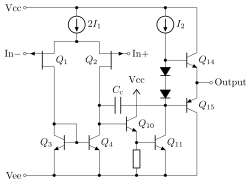

In [3]:
%%tikz -ct -f svg

\ctikzset{american currents, american voltages, european resistors}

### Estimating DC operating point

TI didn't reveal the values of most resistors in its datasheets (see notes below), but we can made educated guess based on the specs and formulas from James E. Solomon's 1974 classic paper [The Monolithic Op Amp: A Tutorial Study](https://web.ece.ucsb.edu/Faculty/rodwell/Classes/ece2c/resources/an-a.pdf).

First from formula (18), slew rate$=\displaystyle\frac{2I_1}{C_c}=13$V/μsec, with $C_c=18$pF, we know $I_1=117$μA, which is the bias current of both JFETs ($I_D$).

Second from formula (16), unity-gain bandwidth $f=\displaystyle\frac{\sm{g}{m1}}{2\pi C_c}=3$MHz, we know transconductance of the input stage $\sm{g}{m1} \approx 0.34$mS.

> *Notes:* [John L. Linsley Hood](https://en.wikipedia.org/wiki/John_Linsley_Hood) made estimation of resistor values in [his 1982 article](https://nuedc.org/opamp/tl072-jlh1982.pdf). Also resistor values are provided in [ST's TL082 datasheets](https://nuedc.org/opamp/tl082-st2016.pdf).

For [JFET in saturation region](https://leachlegacy.ece.gatech.edu/ece3050/notes/jfet/thejfet.pdf), $i_D = I_{DSS}\displaystyle\Big(1-\frac{v_{GS}}{V_{TO}}\Big)^2 = \beta(v_{GS}-V_{TO})^2$, where $I_{DSS} = \beta\, V_{TO}^2$.

> Note $\beta$ here is s SPICE parameter of JFET model, it has nothing to do with BJT's current gain.

In small-signal model, transconductance of JFET is $\sm{g}{m}=2\beta(\uv{GS}-\uv{TO})=2\sqrt{\beta \ui{D}}$

Given $I_D=117$μA and $g_m=0.34$mS, we calculate $\beta = \displaystyle (\frac{g_m}{2})^2 \frac{1}{ I_D}\approx 0.246$ mA/V${{}^2}$

Choose an arbitrary $V_{TO}=-1$V, then $I_{DSS}=0.246$mA, which will be the bias current of Zener diode $D_2$.

Next, we estimate the bias curent of the 2nd stage $I_2$.

The follow schematic shows the bias circuit of TL072/TL082.

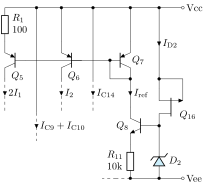

In [79]:
%%tikz -ct -f svg

From the datasheet, we know the supply current per amp is about 1.4mA, that is $2I_1 + I_2 + I_\mathrm{ref}+I_\mathrm{D2} + I_\mathrm{C9,C10,C14}\approx 1.4$mA

We already calculated  $2I_1 = 13\times 18=234$μA, assume $I_\mathrm{C9,C10,C14}\approx 200$μA and $I_\mathrm{D2}\approx 250$μA, we have $I_2 = I_\mathrm{ref}\approx 400$μA.

Determining $R_{11}$:

Assuming $D_2$ breakdown voltage is 5V, and $V_\mathrm{BE8}\approx 0.7$V, then the voltage across $R_{11}$ is about 4.3V. We want $I_\mathrm{ref}=0.4$mA, so $R_{11}\approx\displaystyle\frac{4.3}{0.4}\approx 10$kΩ.

Determining $R_1$, which sets the output current of [Widlar current source](https://en.wikipedia.org/wiki/Widlar_current_source).

$\ui{C5}=2I_1 = 234$μA

$\ui{C5}\,R_1 = V_\mathrm{T}\ln\displaystyle\frac{I_\mathrm{ref}}{\ui{C5}}$

$R_1\approx\displaystyle \frac{26}{234} \log\frac{400}{234} \approx 60$Ω

In [88]:
slew_rate = 13e6
c_comp = 18e-12
Ic5 = slew_rate * c_comp
Iref = 0.4e-3
Vt = 26e-3
R1 = Vt * log(Iref / Ic5) / Ic5
print('Ic5 = %.0f μA, R1 = %.1f Ω' % (Ic5 * 1e6, R1))

Ic5 = 234 μA, R1 = 59.6 Ω


But simulation show $R_1=100$Ω is more appropriate if we take Early effect into account.

In [89]:
ng.circ('''
Vcc vcc 0   15V
Vee vee 0  -15V

* Bias

J16 vcc  vcc  q8b  PJFET
D2  vee  q8b       DZ
Q8  q8c  q8b  q8e  NPN
R11 q8e  vee       10k
Q7  q7c  q7c  vcc  PNP
Q6  q6c  q7c  vcc  PNP
Q5  q5c  q7c  q5e  PNP
R1  vcc  q5e       100

V5  q5c    0  0
V6  q6c    0  0
V7  q7c  q8c  0

.model DZ D(IS=10fA BV=5.0)
.model PJFET PJF(VTO=-1 BETA=0.246e-3 LAMBDA=5e-3)
.model npn NPN (Bf=200 Br=2.0 VAf=130V Is=5fA)
.model pnp PNP (Bf=50 Br=4.0 VAf=50V Is=2fA)

.options savecurrents
''')
print_op(0)

   @d2[id] =  -274.98 uA
  @j16[id] =  -276.79 uA
   @q5[ic] =  -221.35 uA
   @q6[ic] =  -527.88 uA
   @q7[ic] =  -410.32 uA
   @q8[ic] =   430.17 uA
   @r11[i] =   431.98 uA
    @r1[i] =   224.80 uA
       q5c =     0.00 mV
       q5e =   14.978 V
       q6c =     0.00 mV
       q7c =   14.326 V
       q8b =  -10.033 V
       q8c =   14.326 V
       q8e =  -10.680 V
 v5#branch =   221.35 uA
 v6#branch =   527.88 uA
 v7#branch =   430.17 uA
       vcc =   15.000 V
vcc#branch = -1456.20 uA
       vee =  -15.000 V
vee#branch =   706.96 uA


In summary,
* $I_1=117$μA, calculated with slew rate and $C_c$ from spec
* $I_2\approx 0.4$mA, estimated with total supply current from spec
* $\sm{g}{m1}\approx 0.34$mS, calculated with unity gain bandwidth and $C_c$ from spec

In addition, $\beta$ of P-JFET 

### Open-loop gain

Next, we calculate the open-loop gain. Here's full schematic with estimated resistor values in parentheses.

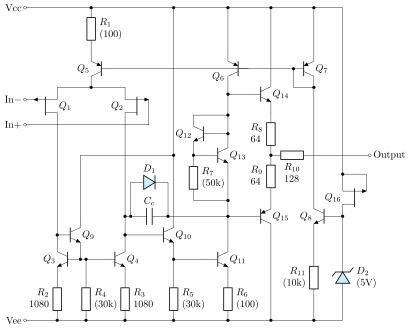

In [4]:
%%tikz -ct -f svg

\ctikzset{american currents, american voltages, european resistors}

#### Input stage small-signal model

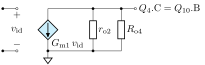

In [23]:
%%tikz -ct -f svg

\ctikzset{american currents, american voltages, european resistors}
\ctikzset{transistors/arrow pos=end, bipoles/length=1.0cm, csources/fill=cyan!20}
\newcommand{\uv}[1]{\ensuremath{V_\mathrm{#1}}}
\newcommand{\sm}[2]{\ensuremath{{#1}_\mathrm{#2}}}

\usetikzlibrary {math}
\tikzmath{\x = 1;\xx=1.6;\y=1.5;}

\draw (0, 0) to [short, *-o] ++(0.5, 0)
  to [open, v={$\sm{v}{id}$}, bipoles/length=0.8cm] ++(0, -\y) coordinate (G)
  to [short, o-*] ++(-0.5, 0);

\draw (\xx, 0) coordinate (G1)
   to [american controlled current source, bipoles/length=1cm] (G1|-G) node [sground] {}
   node [above right] {$\sm{G}{m1}\,\sm{v}{id}$};
\draw (G1) to [short, -*] ++(\xx, 0) coordinate (Ro2)
   to [R, l={$\sm{r}{o2}$}, bipoles/length=0.8cm] ++(0, -\y) node [circ] {};
\draw (Ro2) to [short, -*] ++(\x, 0) coordinate (Ro4)
   to [R, l={$\sm{R}{o4}$}, bipoles/length=0.8cm] ++(0, -\y)  to [short, -*] (G1|-G);
\draw (Ro4) to [short, -o] ++(0.5, 0) node [right] {$Q_4.\mathrm{C}= Q_{10}.\mathrm{B}$};


The output resistor of Q2, $\sm{r}{o2}\approx \displaystyle\frac{1}{\lambda \ui{D}}$, where $\ui{D} = I_1=117$μA, assuming $\lambda = 0.005\mathrm{V}^{-1}$ for P-JFETs, so $\sm{r}{o2}\approx 1.71$MΩ.

The output resistor of Q4, $\sm{R}{o4} = \sm{r}{o4}[1+\sm{g}{m4}(R_3 /\!/ r_{\pi4})]$, where $\sm{r}{o4}\approx\displaystyle\frac{\uv{AN}}{\ui{C4}}$, $\sm{g}{m4}=\displaystyle\frac{\ui{C4}}{\uv{T}}\approx \frac{1}{222\Omega}$, $R_3=1080$Ω, $\ui{C4}\approx I_1=117$μA.

Assuming current gain of NPN is $\sm{\beta}{N}=200$, $r_{\pi4}\approx\displaystyle\frac{\sm{\beta}{N}}{\sm{g}{m4}}\approx 44.4$kΩ. As $r_{\pi4} \gg R_3$, $R_3 /\!/ r_{\pi4} \approx R_3$, $\sm{R}{o4} \approx  \sm{r}{o4}(1+\sm{g}{m4}\, R_3)=\displaystyle \frac{\uv{AN}}{\ui{1}} + \frac{\uv{AN}}{\uv{T}}R_3$.

Assuming Early voltage of NPN is $\uv{AN}=130$V, $\sm{R}{o4} \approx \displaystyle\frac{130}{117}+\frac{130}{0.026}\times 1.08\approx 6.51$MΩ

The output resistor of the first stage $\sm{R}{o1}=\sm{r}{o2} /\!/ \sm{R}{o4}\approx 1.354$MΩ

Transconductance of the first stage $\sm{G}{m1}=\sm{g}{m1}\approx 0.34$mS, so the open-circuit voltage gain of the input stage is $\sm{G}{m1} \sm{R}{o1}\approx 460$.

#### Gain stage

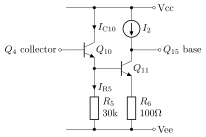

In [68]:
%%tikz -ct -f svg

\ctikzset{american currents, american voltages, european resistors}
\ctikzset{transistors/arrow pos=end, bipoles/length=1.2cm}
\usetikzlibrary {math}
\tikzmath{\x = 0.8;}

\draw (0,0) node [npn] (Q17) {$Q_{11}$};

\draw (Q17.C) to [I, invert, l_={$I_2$},  bipoles/length=1.0cm] ++(0, 1.5) coordinate (VCC);

\draw (VCC) to [short, *-o] ++(0.8, 0) node [right] {Vcc};
\draw (Q17.C) to [short, *-o] ++(1, 0) node [right] {$Q_{15}$ base};

\draw (Q17.B) to [short, -*] ++(-0.6, 0) node [npn, anchor=E] (Q16) {$Q_{10}$};
%\draw (Q16.E) node [left] {$-14.3$V};
\draw (Q16.C) to [short, i_<={$I_\mathrm{C10}$}] ++(0, 0.3)
  to [short, -*] (Q16.C |- VCC) -- (VCC);

\draw (Q16.B) to [short, -o] ++(-0.5, 0) node [left] {$Q_4$ collector};

\draw (Q17.E) % node [currarrow, rotate=-90] {} node [right] {$I_\mathrm{E17}$}
  to [R, l2={$R_{6}$ and 100$\Omega$},bipoles/length=1.0cm] ++(0, -1.5) coordinate (G);
\draw (G) to [short, *-o] ++(0.8, 0) coordinate (VEE) node [right] {Vee};

\draw (G) to [short, -*] (G-|Q16.E)
  to [R, l2_={$R_{5}$ and 30k},bipoles/length=1.0cm] (Q16.E |- Q17.E)
  node [currarrow, rotate=-90] {}
  node [right] {$I_\mathrm{R5}$} -- (Q16.E);
\draw (G-|Q16.E) to [short] ++(-1.0, 0);
\draw (Q16.C |- VCC) -- ++(-1, 0);

We want to calculate the following parameters of the intermediate gain stage. Q11 is a common-emitter amplifier with emitter resistor $R_6$.
 * Transconductance of this stage $\sm{G}{m2}\approx\displaystyle\frac{1}{1/\sm{g}{m11}+R_6}$, where
$\sm{g}{m11}=\displaystyle\frac{I_2}{\uv{T}}=\frac{1}{65\Omega}$, so $\sm{G}{m2}\approx\displaystyle\frac{1}{165\Omega}$
 * Input resistance $\ur{i2}$, which is input resistance of Q10: $\ur{i10}$

 * Output resistance $\ur{o2}=\sm{r}{o6}/\!/\ur{o11}$, where $\sm{r}{o6}\approx\dfrac{\uv{AP}}{I_2}=125$kΩ, and $\sm{R}{o11} \approx  \sm{r}{o11}(1+\sm{g}{m11}\, R_6)=\displaystyle \frac{\uv{AN}}{I_2} + \frac{\uv{AN}}{\uv{T}}R_6=825$kΩ. So $\ur{o2}=\sm{r}{o6}/\!/\ur{o11}\approx108.6$kΩ

 * Voltage gain of the gain stage $\sm{A}{v2}=\sm{G}{m2}\,\ur{o2}\approx 658$

Let's consider Q10, which is a emitter follower, its emitter resistor is $\ur{E10}=R_5/\!/\ur{i11}$
 * The input resistance of Q11 is $\ur{i11}=r_{\pi 11} + (1+\sm{\beta}{N})R_6$, where $r_{\pi 11}=\displaystyle\frac{\sm{\beta}{N}}{\sm{g}{m11}}=13$kΩ, so $\ur{i11}=13+(1+200)\times 0.1=33.1$kΩ.
 * The emitter resistor of Q10 is $\ur{E10}=R_5/\!/\ur{i11}\approx 15.7$kΩ
 * The emitter current of Q10 is $\ui{E10}=\ui{R5}+\ui{B11}$, the voltage across $R_5$ is about $\uv{BE11}$, which assumed to be 0.7V, so $\ui{E10}=\dfrac{0.7}{30}+\dfrac{I2}{\sm{\beta}{N}}\approx 25.3$μA.
 * $\sm{g}{m10}=\dfrac{\ui{C10}}{\uv{T}}\approx \dfrac{1}{1026\Omega}$, $r_{\pi 10}=\dfrac{\sm{\beta}{N}}{\sm{g}{m10}}\approx 205.3$kΩ
 * The input resistance of Q10 is $\ur{i10}=r_{\pi 10}+ (1+\sm{\beta}{N})\ur{E10}\approx 205.3 + (1+200)\times 15.7\approx 3.53$MΩ, that is $\ur{i2}\approx 3.53$MΩ.


#### Small-signal model of TL072

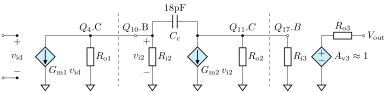

In [54]:
%%tikz -ct -f svg

\ctikzset{american currents, american voltages, european resistors}

The voltage gain of first stage $\sm{A}{v1}=\sm{G}{m1}(\ur{o1}/\!/\ur{i2})\approx 332$

The output stage is class AB push-pull circuit, which has high input resistance, so $\ur{i3}\gg\ur{o2}$, and $\sm{A}{v3}\approx 1$

The total voltage gain $\sm{A}{vd}=\sm{G}{m1}(\ur{o1}/\!/\ur{i2})\,\sm{G}{m2}(\ur{o2}/\!/\ur{i3})\,\sm{A}{v3}\approx 332 \times 658 \approx 2.18\times 10^{5}$, that is about 218 V/mV.

## Simulation

### Open-loop gain

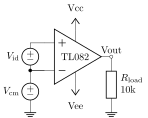

In [4]:
%%tikz -ct -f svg

\ctikzset{baseline, american currents, american voltages, european resistors}

\draw (0, 0) node [op amp, noinv input up] (OA) {TL082};

\draw (OA.+) to [short] ++(-0.5, 0) coordinate (IN)
  to [V, l_={$V_\mathrm{id}$}, bipoles/length=1cm] (IN|-OA.-) -- (OA.-);
\draw (OA.-) to [short, -*] ++(-0.5, 0) coordinate (INV)
  to [V, l_={$V_\mathrm{cm}$}, bipoles/length=1cm] ++(0, -1.5) coordinate (G) node [tlground] {};
\draw (OA.out) node [ocirc] {} node [above] {Vout}
  to [R,l2={$R_\mathrm{load}$ and 10k},  bipoles/length=1.2cm] (OA.out|-G) node [tlground] {};
\draw (OA.up) -- ++(0, 0.4) node [vcc] {Vcc};
\draw (OA.down) -- ++(0, -0.4) node [vee] {Vee};

In [12]:
ng.circ('''
Vcc   vcc  0   15V
Vee   vee  0  -15V

Vid   in+  in-  DC 86.3u AC 1V
Vcm   in-  0    0
Rload out  0    10k

* Bias

J16 vcc  vcc q8b PJFET
D2  vee  q8b     DZ
Q8  q7c  q8b q8e NPN
R11 q8e  vee     10k
Q7  q7c  q7c vcc PNP
Q6  q14b q7c vcc PNP
Q5  q5c  q7c q5e PNP
R1  vcc  q5e     100

* Input

J1 q3c  in- q5c PJFET
J2 q10b in+ q5c PJFET2
Q3 q3c  q3b r2  NPN
Q4 q10b q3b r3  NPN
Q9 vcc  q3c q3b NPN
R2 r2   vee     1080
R3 r3   vee     1080
R4 q3b  vee     30k
*C1 r2  vee     15pF

* Gain

Q10  vcc  q10b  q11b NPN
Q11 q15b q11b r6   NPN
R5  q11b vee  30k
R6  r6   vee  100
C2  q10b  q15b 18pF
D1  q10b  q15b D

* Vbe multiplier

Q12 q14b q14b q13b NPN
Q13 q14b q13b q15b NPN
R7  q13b q15b 50k

* Output

Q14 vcc q14b q14e NPN 3
Q15 vee q15b q15e PNP 3
R8  q14e mid  64
R9  mid  q15e 64
R10 mid  out  128

.model DZ D(IS=10fA BV=5.0)
.model D D(IS=1fA)
.model PJFET PJF(VTO=-1 BETA=0.246e-3 LAMBDA=5e-3)
.model PJFET2 PJF(VTO=-1 BETA=0.246e-3 LAMBDA=5e-3)

.model npn NPN ( Bf=200 Br=2.0 VAf=130V Is=5fA Tf=0.35ns
+ Rb=200 Rc=200 Re=2 Cje=1.0pF Vje=0.70V Mje=0.33 Cjc=0.3pF
+ Vjc=0.55V Mjc=0.5 Cjs=3.0pF Vjs=0.52V Mjs=0.5)

.model pnp PNP ( Bf=50 Br=4.0 VAf=50V Is=2fA Tf=30ns
+ Rb=300 Rc=100 Re=10 Cje=0.3pF Vje=0.55V Mje=0.5 Cjc=1.0pF
+ Vjc=0.55V Mjc=0.5 Cjs=3.0pF Vjs=0.52V Mjs=0.5)
''')
print_op()

       in+ =     0.09 mV
       in- =     0.00 mV
       mid =    -2.10 mV
       out =    -2.08 mV
      q10b =  -13.721 V
      q11b =  -14.295 V
      q13b =    33.12 mV
      q14b =   598.40 mV
      q14e =     6.98 mV
      q15b =  -622.82 mV
      q15e =   -11.20 mV
       q3b =  -14.254 V
       q3c =  -13.680 V
       q5c =  -328.50 mV
       q5e =   14.976 V
       q7c =   14.320 V
       q8b =  -10.033 V
       q8e =  -10.681 V
        r2 =  -14.872 V
        r3 =  -14.872 V
        r6 =  -14.949 V
       vcc =   15.000 V
vcc#branch = -1641.94 uA
vcm#branch =    -0.03 nanoA
       vee =  -15.000 V
vee#branch =  1642.15 uA
vid#branch =    -0.01 nanoA


Output swing -13.18 to 14.00


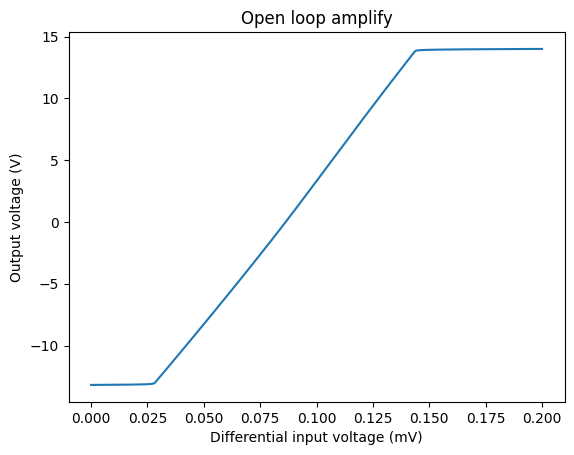

In [9]:
ng.cmd('dc vid 0u 200u 0.1u')
Vin = ng.vector('in+')
Vout = ng.vector('out')
plt.plot(Vin*1e3, Vout)
cross = sum(Vout < 0)
plt.xlabel('Differential input voltage (mV)')
plt.ylabel('Output voltage (V)')
plt.title('Open loop amplify')
print('Output swing %.2f to %.2f' % (min(Vout), max(Vout)))

In [10]:
cross_point = np.sum(Vout < 0)
assert Vout[cross_point] > 0 and Vout[cross_point-1] < 0
print('Vos = %.1f uV Vout = %.1f mV' % (Vin[cross_point] * 1e6, Vout[cross_point]*1e3))

assert Vout[0] < -10 and Vout[-1] > 10
start = np.sum(Vout < -10)
end =  np.sum(Vout < 10)
deltaVin = Vin[end] - Vin[start]
print('Delta Vin for 10V delta in Vout: %.1f uV' % (1e6*deltaVin/2))
deltaVout = Vout[end] - Vout[start]
gain = deltaVout / deltaVin
print('Gain = %.0f V/mV, %.1f dB' % (gain/1e3, 20*log10(gain)))

Vos = 86.4 uV Vout = 21.7 mV
Delta Vin for 10V delta in Vout: 42.7 uV
Gain = 234 V/mV, 107.4 dB


Output range: -13.36 V to 14.07 V


(-15.0, 15.0)

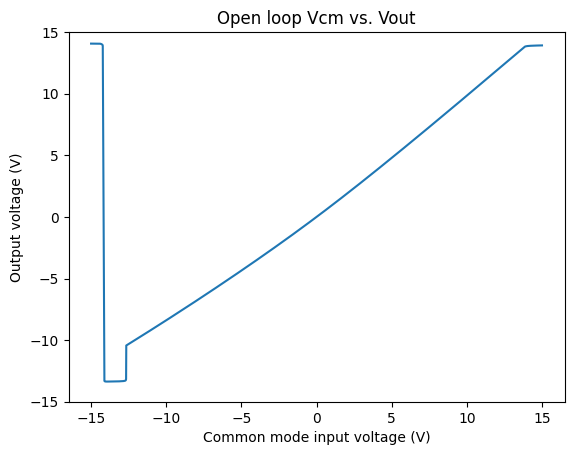

In [13]:
ng.cmd('dc vcm -15V 15V 1m')

Vout = ng.vector('out')
Vin = ng.vector('in-')
plt.plot(Vin, Vout)
plt.xlabel('Common mode input voltage (V)')
plt.ylabel('Output voltage (V)')
plt.title('Open loop Vcm vs. Vout')
print('Output range: %.2f V to %.2f V' % (min(Vout), max(Vout)))
plt.ylim([-15, 15])

### DC transfer function

In [14]:
ng.cmd('tf v(out) vid')
ng.vectors()

{'output_impedance_at_V(out)': array([1258.36662401]),
 'vid#Input_impedance': array([2.74265901e+09]),
 'Transfer_function': array([237458.95448348])}

In [15]:
ng.cmd('tf v(out) vcm')
ng.vectors()

{'output_impedance_at_V(out)': array([1258.36662401]),
 'vcm#Input_impedance': array([4.97225885e+11]),
 'Transfer_function': array([0.9148618])}

### Frequency response

Gain at        0 Hz is  237451.96  Phase   -0.5 deg 
Gain at        1 Hz is  236728.56  Phase   -4.5 deg 
Gain at       10 Hz is  186662.49  Phase  -38.2 deg 
Gain at      100 Hz is   29957.04  Phase  -82.8 deg 
Gain at     1000 Hz is    3019.59  Phase  -89.3 deg 
Gain at    10000 Hz is     301.98  Phase  -90.1 deg 
Gain at   100000 Hz is      30.18  Phase  -92.0 deg 
Gain at  1000000 Hz is       2.85  Phase -108.9 deg 
Gain at 10000000 Hz is       0.10  Phase -160.2 deg 
Gain 107.5 dB
2.51 MHz


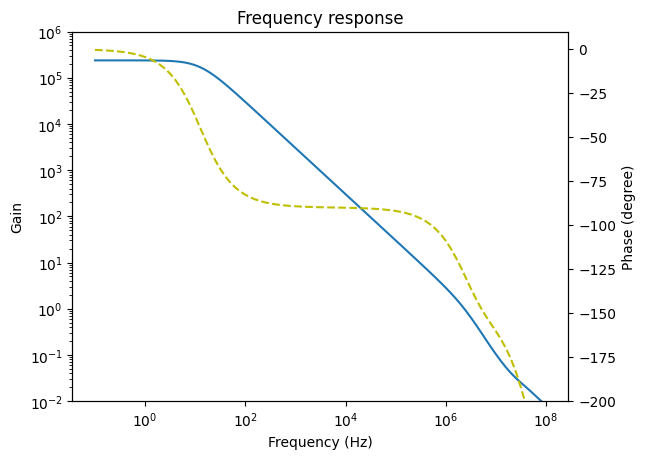

In [16]:
ng.cmd('AC dec 10 0.1Hz 100MegHz')
freq = ng.vector('frequency')
out = ng.vector('out')

fig, ax = plt.subplots()
plt.loglog(freq, np.abs(out))
plt.title('Frequency response')
plt.ylabel('Gain')
plt.xlabel('Frequency (Hz)')
for i in range(len(freq)):
    if int(freq[i]*100) in np.power(10, range(10)):
        print('Gain at %8.0f Hz is %10.2f  Phase %6.1f deg ' % (freq[i], np.abs(out[i]), degrees(np.angle(out[i]))))
plt.ylim(1e-2, 1e6)

ax2 = ax.twinx()
phase =  np.unwrap(np.angle(out))/math.pi*180
plt.semilogx(freq, phase, '--y')

plt.ylim(-200, 10)
plt.ylabel('Phase (degree)')

print('Gain %.1f dB' % (log10(np.abs(out[0]))*20))
cross = sum(np.abs(out) > 1)
print('%.2f MHz' % (freq[cross]/1e6))

### Slew-rate

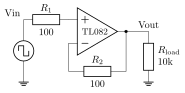

In [17]:
%%tikz -ct -f svg

\ctikzset{american currents, american voltages, european resistors}
\ctikzset{diodes/fill=cyan!20, transistors/arrow pos=end,bipoles/length=1.2cm}

\draw (0, 0) node [op amp, noinv input up] (OA) {\small TL082};

\draw (OA.-) to [short] ++(0, -1) coordinate (INV)
  to [R,l={$R_2$}, a={$100$}] (INV-|OA.out) -- (OA.out);
\draw (OA.out) to [short, *-] ++(0.8, 0) node [above] {Vout}
  to [R,l2={$R_\mathrm{load}$ and 10k}] ++(0, -1.8)  coordinate (G) node [tlground] {};
\draw (OA.+)
  to [R, l_={$R_1$}, a^=100] ++(-1.6, 0) coordinate (VIN)
 node [above left] {Vin}
  to [sqV] (VIN|-G) node [tlground] {};


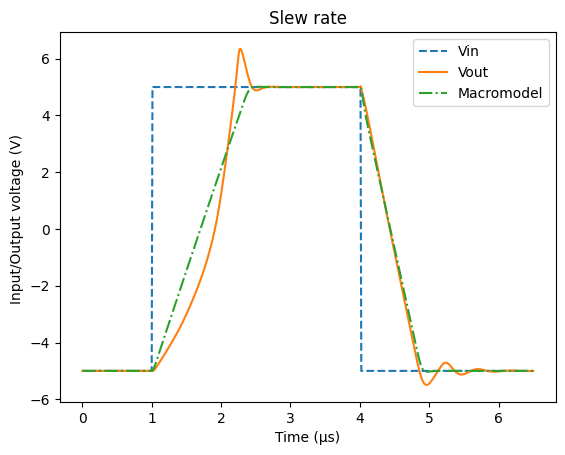

In [40]:
ng.circ('''
* power supplies

V1  vcc 0  15V
V2  vee 0 -15V

Vin  vin    0   DC -5 PULSE -5 5 1u 10N 10N 3U 100U 
R1   in+  vin   100
R2   in-  out   100

Rload out    0   10000

X  in+ in- vcc vee out TL082
X2 vin out2 vcc vee out2 TL082M

.include tl082.cir

*.options savecurrents
''')
ng.cmd('tran 10n 6.5u')
t = ng.vector('time')
Vout = ng.vector('out')
Vout2 = ng.vector('out2')
Vin = ng.vector('vin')
plt.plot(t*1e6, Vin, '--', label='Vin')
plt.plot(t*1e6, Vout, label='Vout')
plt.plot(t*1e6, Vout2, '-.', label='Macromodel')
plt.ylabel('Input/Output voltage (V) ')
plt.xlabel('Time (μs)')
plt.title('Slew rate')
plt.legend()

### Phase reversal

ERROR:ngspyce.sharedspice:Note: Starting dynamic gmin stepping
ERROR:ngspyce.sharedspice:Note: Dynamic gmin stepping completed


Output range: 1.25 V to 14.07 V


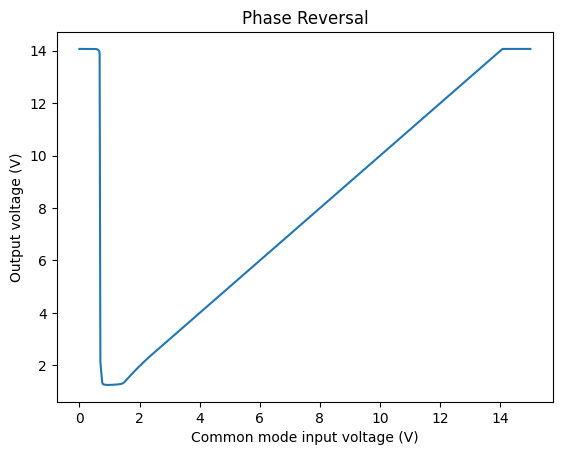

In [28]:
ng.circ('''
* power supplies
V1  vcc 0  15V
V2  vee 0  0V

Vin  vin    0    2V
R1   in+  vin  100
R2   in-  out  100

Rload out    0   10000

X  in+ in- vcc vee out TL082

.include tl082.cir
.options savecurrents
''')
# print_op(0)
ng.cmd('dc vin 0V 15V 1m')

Vout = ng.vector('out')
Vin = ng.vector('vin')
# plt.figure(figsize=(4, 3))
plt.plot(Vin, Vout)
plt.xlabel('Common mode input voltage (V)')
plt.ylabel('Output voltage (V)')
plt.title('Phase Reversal')
print('Output range: %.2f V to %.2f V' % (min(Vout), max(Vout)))

### Input offset voltage